# Project: Bank Customer Churn Prediction
## Preprocessing, Modeling & Hyperparameter Tuning

**Objectives:**

- Build a pipeline for in-depth data processing (Ordinal/Nominal Encoding, Robust Scaling).

- Address data imbalance issues using SMOTE (Synthetic Minority Over-sampling Technique) in a closed process to prevent data leakage.

- Optimize parameters (Hyperparameter Tuning) for the two most powerful models: **Random Forest** and **XGBoost**.

- Evaluate the model based on Recall and F1-Score (Prioritizing customer churn detection).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import os
import shap

# Sklearn Modules
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Imbalanced-learn 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Cấu hình
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
custom_palette = {0: 'tab:blue', 1: 'tab:red'}

print("Libraries imported. Ready for advanced modeling.")

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported. Ready for advanced modeling.


## Load Data & Train-Test Split
**Golden Rule:** Split the Train/Test set immediately. The Test set must be "pure" data, untouched by any processing steps (including calculating the mean to fill in missing or SMOTE values) to ensure the most honest evaluation results.

In [2]:
# Read file
current_dir = os.getcwd()
file_path = os.path.join(current_dir, '..', 'data', 'processed', 'BankChurners_Cleaned_Featured.csv')
df = pd.read_csv(file_path)
print(f"Data Loaded Successfully. Shape: {df.shape}")

# Split Feature and Target
X = df.drop('Attrition_Flag', axis=1)
y = df['Attrition_Flag']

# 80% Train - 20% Test
# stratify=y: Ensures the Churn rate is the same in both sets (important for unbalanced data).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Set: {X_train.shape}")
print(f"Test Set:     {X_test.shape}")

Data Loaded Successfully. Shape: (10127, 23)
Training Set: (8101, 22)
Test Set:     (2026, 22)


## Preprocessing Pipeline
We set up separate processing logic for each variable type:
1. **Ordinal Features** (Education, Income, Card): Use `OrdinalEncoder` with a manually defined order. This helps the model understand *Doctorate > Graduate*.

2. **Nominal Features** (Gender, Marital): Use `OneHotEncoder`.

3. **Numerical Features**: Use `RobustScaler`. This scaler uses the interquartile range (IQR) instead of Mean/Std, so it tolerates outliers (noise) in financial data better.

In [3]:
# --- 1. Column Grouping ---
# Numerical Columns (including the new feature created in step 1)
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Ordinal Columns
ordinal_cols = ['Education_Level', 'Income_Category', 'Card_Category']

# Nominal Columns
nominal_cols = ['Gender', 'Marital_Status']

# --- 2. Defining the Order for the Ordinal Encoder ---
# 'Unknown' must be included to avoid errors if the actual data has this value
edu_order = ['Unknown', 'Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate']
income_order = ['Unknown', 'Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +']
card_order = ['Blue', 'Silver', 'Gold', 'Platinum']

# --- 3. Create child Pipeline ---
# Numeric Pipeline: Fill in missing (Median) -> RobustScaler
num_pipeline = ImbPipeline(steps=[ 
('imputer', SimpleImputer(strategy='median')), 
('scaler', RobustScaler())
])

# Pipeline Ordinal: Fill in missing -> OrdinalEncoder
ord_pipeline = ImbPipeline(steps=[ 
('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), 
('ord', OrdinalEncoder(categories=[edu_order, income_order, card_order], handle_unknown='use_encoded_value', unknown_value=-1))
])

# Pipeline Nominal: Fill in missing -> OneHotEncoder
nom_pipeline = ImbPipeline(steps=[ 
('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), 
('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# --- 4. Summary of ColumnTransformer ---
preprocessor = ColumnTransformer( 
transformers=[ 
('num', num_pipeline, numerical_cols), 
('ord', ord_pipeline, ordinal_cols), 
('nom', nom_pipeline, nominal_cols) 
], 
remainder='drop'
)

print("Preprocessing Pipeline configured.")

Preprocessing Pipeline configured.


## Hyperparameter Tuning with SMOTE
We will optimize two models: **Random Forest** and **XGBoost**.

**Tuning Process (RandomizedSearchCV):**
1. For each iteration, the training data is split (Cross-Validation).

2. On each of these smaller parts: **SMOTE** is applied to balance the data -> Then the model is trained.

3. Evaluation Metric: **Recall** (to maximize the ability to capture customers leaving) or **F1-Score**.

In [4]:
def tune_model(model, param_grid, name):
    # Create overall Pipeline: Preprocessing -> SMOTE -> Model
    pipeline = ImbPipeline(steps=[
                ('preprocessor', preprocessor),
                ('smote', SMOTE(random_state=42)), # Only run when fit on training set
                ('classifier', model)
    ])

    # Set RandomizedSearchCV
    search = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=param_grid,
                n_iter=20, # Number of test parameter combinations
                scoring='recall', # Prioritize Recall to avoid missing customers leaving
                cv=3, # Cross-validation 3-fold
                verbose=1,
                random_state=42,
                n_jobs=-1 # Run in parallel multi-threading
    )

    search.fit(X_train, y_train) 

    print(f"Best Params ({name}): {search.best_params_}") 
    print(f"Best Recall Score (CV): {search.best_score_:.4f}") 

    return search.best_estimator_

In [5]:
# --- 1. Random Forest Tuning ---
rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

rf_best = tune_model(RandomForestClassifier(random_state=42), rf_params, "Random Forest")


# --- 2. XGBoost Tuning ---
xgb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.7, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.9, 1.0]
}

xgb_best = tune_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), 
                      xgb_params, "XGBoost")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params (Random Forest): {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 10}
Best Recall Score (CV): 0.9032
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params (XGBoost): {'classifier__subsample': 1.0, 'classifier__n_estimators': 300, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.9}
Best Recall Score (CV): 0.9094


## Final Evaluation
Evaluate the best model on the test set (Hold-out set).

We will carefully examine:
- **Classification Report:** Especially the `class 1` (Churn) line.

- **Confusion Matrix:** To clearly see the number of False Negatives (Customers leaving but the machine predicts they will stay - the highest risk).

- **ROC-AUC:** Evaluate the overall classification power.


================ Tuned Random Forest PERFORMANCE ================
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1701
           1       0.67      0.96      0.79       325

    accuracy                           0.92      2026
   macro avg       0.83      0.93      0.87      2026
weighted avg       0.94      0.92      0.92      2026

ROC-AUC Score: 0.9854


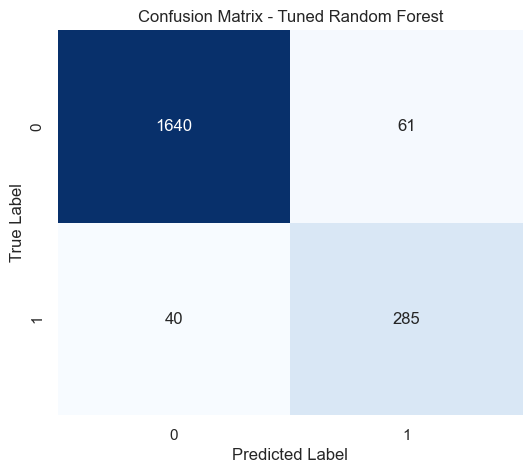


================ Tuned XGBoost PERFORMANCE ================
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1701
           1       0.89      0.91      0.90       325

    accuracy                           0.97      2026
   macro avg       0.94      0.94      0.94      2026
weighted avg       0.97      0.97      0.97      2026

ROC-AUC Score: 0.9930


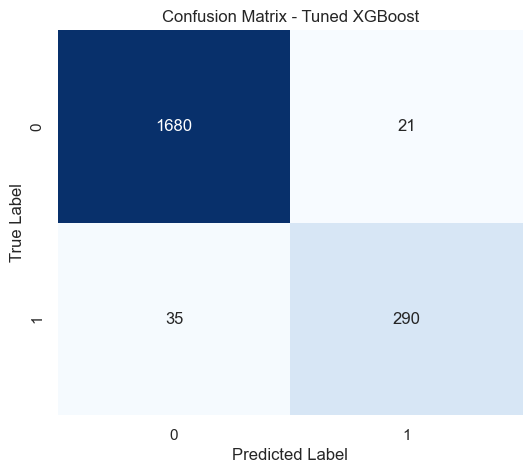

In [6]:
def evaluate_model(model, name): 
    print(f"\n================ {name} PERFORMANCE ================") 

    # Forecast on Test set 
    y_pred = model.predict(X_test) 
    y_prob = model.predict_proba(X_test)[:, 1] 
    y_pred_new_threshold = (y_prob >= 0.3).astype(int) 

    # 1. Classification Report 
    print(classification_report(y_test, y_pred_new_threshold)) 

    #2. ROC-AUC 
    auc = roc_auc_score(y_test, y_prob) 
    print(f"ROC-AUC Score: {auc:.4f}") 

    #3. Confusion Matrix 
    plt.figure(figsize=(6, 5)) 
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Evaluate the two optimized models
evaluate_model(rf_best, "Tuned Random Forest")
evaluate_model(xgb_best, "Tuned XGBoost")

## Feature Importance
Understand which factors have the strongest impact on customer churn.

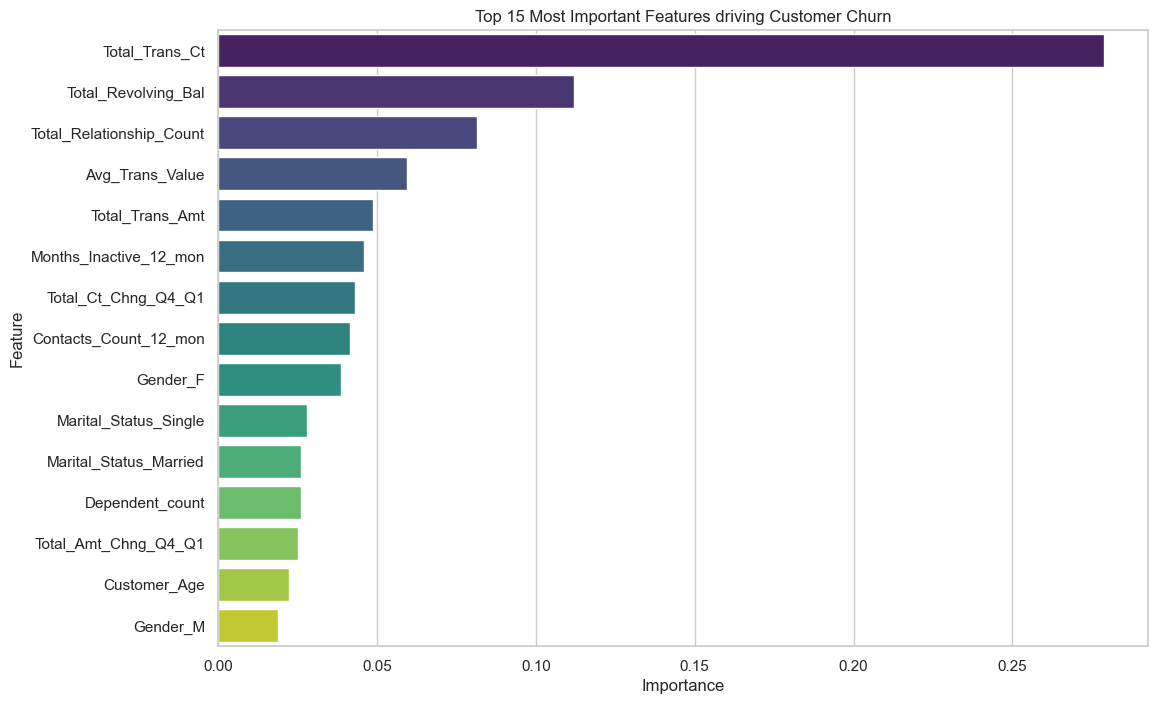

In [7]:
# Assume XGBoost is the best model
best_model = xgb_best

# Get feature names from the preprocessor (slightly complex as it goes through a pipeline)
onehot_features = best_model.named_steps['preprocessor'].named_transformers_['nom']['onehot'].get_feature_names_out(nominal_cols)
all_features = numerical_cols + ordinal_cols + list(onehot_features)
# Get the importance value
importances = best_model.named_steps['classifier'].feature_importances_
# Create a DataFrame and sort
feature_imp = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_imp = feature_imp.sort_values(by='Importance', ascending=False).head(15)
# Draw a chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')
plt.title('Top 15 Most Important Features driving Customer Churn')
plt.show()


## Model Explainability with SHAP Values
To prevent the model from being a "black box," we use **SHAP** to explain the predictions.

- **SHAP Summary Plot:** Indicates which feature is most important and its direction of impact (Example: *Lower total transactions -> Higher likelihood of abandonment*).

In [8]:
import shap

# 1. Obtain the model and preprocessor from the best Pipeline
# Assuming xgb_best is your final chosen model
target_model = xgb_best 

# Separate the data processing (preprocessor) and algorithm (classifier) ​​components.
preprocessor = target_model.named_steps['preprocessor']
classifier = target_model.named_steps['classifier']

# 2. Reconstructing the input data for SHAP
# Because SHAP needs to know the actual value that the model sees (after scaling and encoding)
# We transform the X_test set through the preprocessor
X_test_processed = preprocessor.transform(X_test)

# Convert the sparse matrix into a dense array (if using OneHotEncoder) for easier processing by SHAP.
if hasattr(X_test_processed, 'toarray'):
    X_test_processed = X_test_processed.toarray()

# 3. Retrieve the column names (Feature Names)
# This step is important so that the chart displays the column name "Trans_Amt" instead of "Feature 0, Feature 1"
try:
    # Get column names from each transformer in the pipeline
    num_names = numerical_cols
    ord_names = ordinal_cols
    # With OneHotEncoder, column names will generate multiple child columns (e.g., Gender_M, Gender_F).
    nom_names = preprocessor.named_transformers_['nom']['onehot'].get_feature_names_out(nominal_cols)
    
    # Combine everything in the correct order in ColumnTransformer
    feature_names = np.r_[num_names, ord_names, nom_names]
except Exception as e:
    print(f"Cannot get column name automatically ({e}). Use index instead.")
    feature_names = [f"Feature {i}" for i in range(X_test_processed.shape[1])]

#4. Calculate SHAP Values
print("Calculating SHAP values ​​(may take a few seconds)...")
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test_processed)

# Note: If using Random Forest, shape_values ​​will be list [class0, class1]. We choose class 1.
if isinstance(shap_values, list):
    shap_values = shap_values[1]

print("The SHAP values ​​have been calculated.")

Calculating SHAP values ​​(may take a few seconds)...
The SHAP values ​​have been calculated.


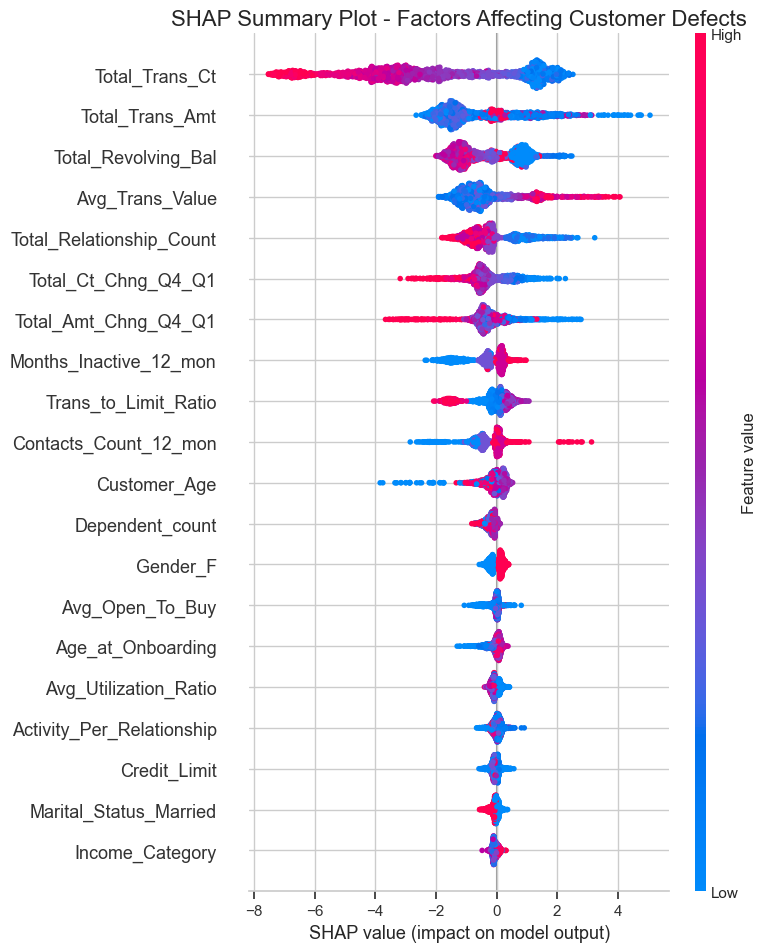

In [9]:
# Draw a Summary Plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - Factors Affecting Customer Defects", fontsize=16)
plt.show()


## Individual Prediction Explanation (Bonus)
Try explaining to a specific customer (e.g., the first customer in the test set) why the machine predicts they will leave/stay.
This is a great tool for customer service representatives when advising individual clients.

Explain forecast for customer index 5:
Actual: Stay


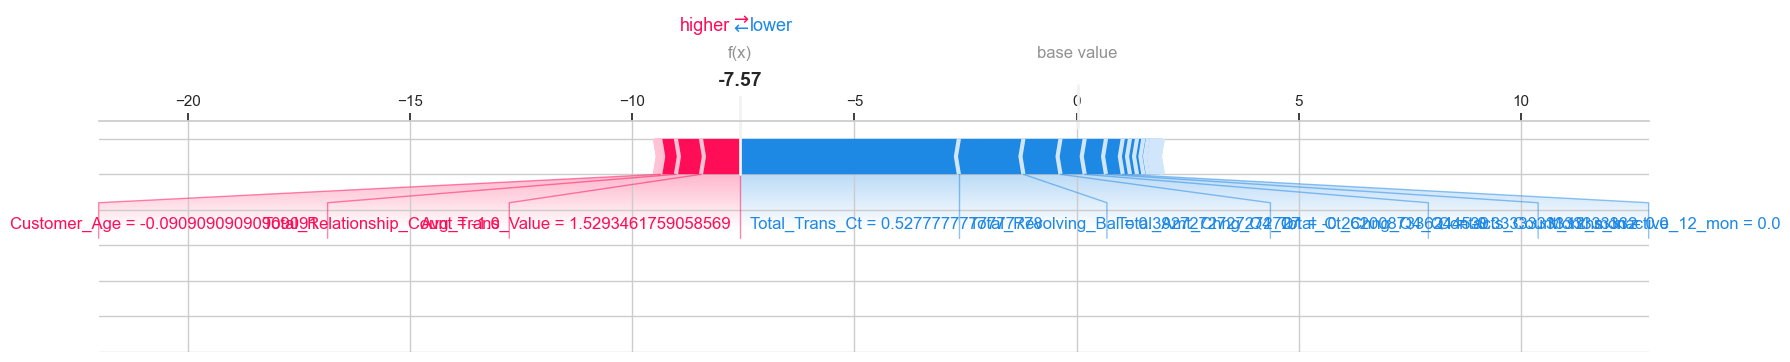

In [10]:
# Initialize Javascript for the interactive chart
shap.initjs()

# Select any customer (e.g., line 5 in X_test)
idx = 5

print(f"Explain forecast for customer index {idx}:")

print(f"Actual: {'Leave' if y_test.iloc[idx]==1 else 'Stay'}")

# Draw a Force Plot
shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_test_processed[idx],
    feature_names=feature_names,
    matplotlib=True
)

## Save Final Model
Export the best model to a `.pkl` file. This file contains the entire pipeline (data processing + model), making deployment extremely simple later: just input the raw data and you'll get the results.

In [14]:
import os

final_model = xgb_best
save_dir = os.path.join('..', 'models')
os.makedirs(save_dir, exist_ok=True)
file_name = 'churn_prediction_pipeline.pkl'
full_path = os.path.join(save_dir, file_name)

# Save file
joblib.dump(final_model, full_path)

print(f"Model saved successfully: {full_path}")
print("Ready for API build (FastAPI)!")

Model saved successfully: ..\models\churn_prediction_pipeline.pkl
Ready for API build (FastAPI)!
